2023-07-28 14:54:41.491697: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-07-28 14:54:41.491722: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-07-28 14:54:41.491726: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-07-28 14:54:41.491794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-28 14:54:41.492136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-07-28 14:54:42.473630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 8ms/step


2023-07-28 14:54:44.010912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CNN MSE: 0.013276862054713182
CNN MAE: 0.07631390288317003


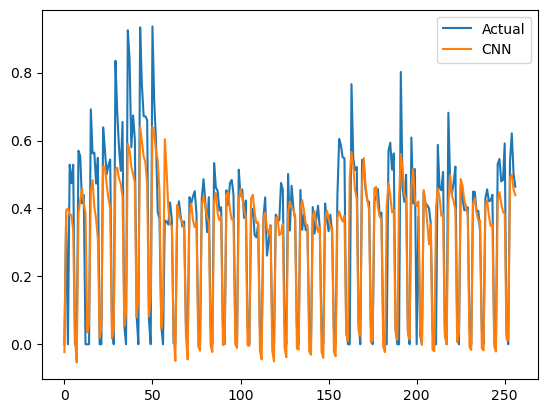

2023-07-28 14:54:44.596585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 17ms/step


2023-07-28 14:55:04.282584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


LSTM MSE: 0.013185684674080047
LSTM MAE: 0.07138161692560435


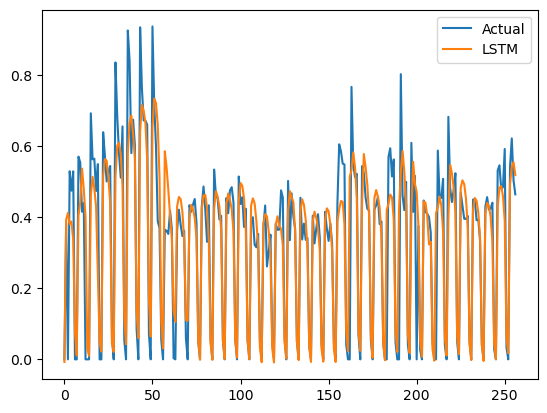

2023-07-28 14:55:05.248394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/9 [===============>..............] - ETA: 0s

2023-07-28 14:55:46.391366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 29ms/step
ConvLSTM MSE: 0.013580305713071094
ConvLSTM MAE: 0.07583788772020778


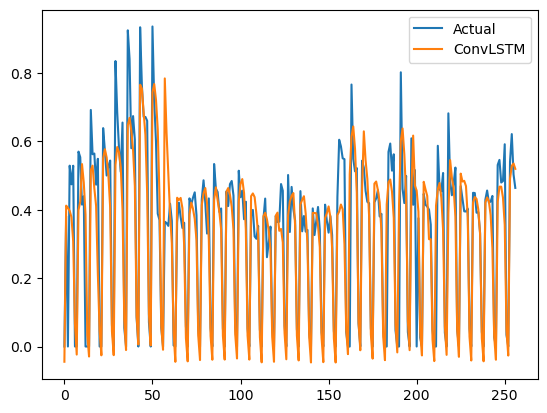

2023-07-28 14:55:47.137494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 14ms/step


2023-07-28 14:56:07.030727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


GRU MSE: 0.01738183440732781
GRU MAE: 0.0928620800637311


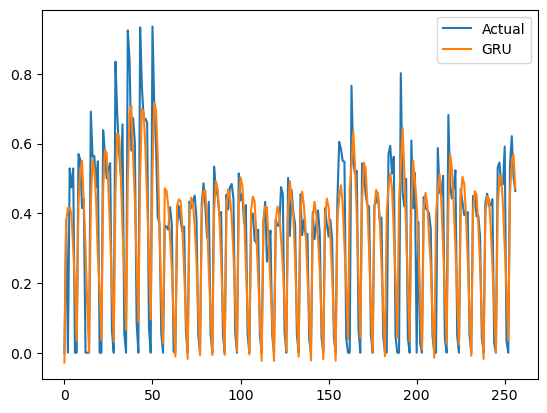

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, Flatten
from tensorflow.keras.layers import ConvLSTM2D, Reshape
import matplotlib.pyplot as plt

# Read main data
data = pd.read_excel('/Users/anthony/spyder-py3/ML/traffic_tg1.xlsx', index_col='date')
data.index = pd.to_datetime(data.index)

# Read holiday day data
holidays_data = pd.read_excel('/Users/anthony/spyder-py3/ML/public_holiday.xlsx')
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

# Create a dummy for holiday
data['is_holiday'] = data.index.isin(holidays_data['date']).astype(int)

# Create a dummy for sunday
data['is_sunday'] = (data.index.dayofweek == 6).astype(int)

# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# We will use 7 days as a time step for our models
X = []
y = []
for i in range(7, len(data_scaled)):
    X.append(data_scaled[i-7:i, :])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)

# Train-test split (80% for training, 20% for testing)
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Model training
model_names = ["CNN", "LSTM", "ConvLSTM", "GRU"]
models = [
    Sequential([Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(7, X_train.shape[2])),
                Flatten(),
                Dense(1)]),
    Sequential([LSTM(50, activation='relu', input_shape=(7, X_train.shape[2])),
                Dense(1)]),
    Sequential([ConvLSTM2D(filters=64, kernel_size=1, activation='relu', input_shape=(7, 1, 1, X_train.shape[2])),
                Flatten(),
                Dense(1)]),
    Sequential([GRU(50, activation='relu', input_shape=(7, X_train.shape[2])),
                Dense(1)])
]

# Reshape data for ConvLSTM2D
X_train_reshaped = X_train.reshape((X_train.shape[0], 7, 1, 1, X_train.shape[2]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 7, 1, 1, X_test.shape[2]))

for model_name, model in zip(model_names, models):
    if model_name == "ConvLSTM":
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_reshaped, y_train, epochs=10, verbose=0)
        predictions = model.predict(X_test_reshaped)
    else:
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=10, verbose=0)
        predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f"{model_name} MSE: {mse}")
    print(f"{model_name} MAE: {mae}")
    
    plt.plot(y_test, label="Actual")
    plt.plot(predictions, label=model_name)
    plt.legend()
    plt.show()


In [ ]:
# Determine the index for the last month
last_month_start_index = np.where(data.index >= (data.index.max() - pd.DateOffset(months=1)))[0][0]

# Model training
model_names = ["CNN", "LSTM", "ConvLSTM", "GRU"]
models = [
    Sequential([Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(7, X_train.shape[2])),
                Flatten(),
                Dense(1)]),
    Sequential([LSTM(50, activation='relu', input_shape=(7, X_train.shape[2])),
                Dense(1)]),
    Sequential([ConvLSTM2D(filters=64, kernel_size=1, activation='relu', input_shape=(7, 1, 1, X_train.shape[2])),
                Flatten(),
                Dense(1)]),
    Sequential([GRU(50, activation='relu', input_shape=(7, X_train.shape[2])),
                Dense(1)])
]

# Reshape data for ConvLSTM2D
X_train_reshaped = X_train.reshape((X_train.shape[0], 7, 1, 1, X_train.shape[2]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 7, 1, 1, X_test.shape[2]))

for model_name, model in zip(model_names, models):
    if model_name == "ConvLSTM":
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_reshaped, y_train, epochs=10, verbose=0)
        predictions = model.predict(X_test_reshaped)
    else:
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=10, verbose=0)
        predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f"{model_name} MSE: {mse}")
    print(f"{model_name} MAE: {mae}")
    
    plt.plot(y_test, label="Actual")
    plt.plot(predictions, label=model_name)
    plt.legend()
    plt.show()
    
    # Plot last month data
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[last_month_start_index-split:], label="Actual")
    plt.plot(predictions[last_month_start_index-split:], label=model_name)
    plt.legend()
    plt.title(f"{model_name} - Last Month Predictions")
    plt.show()


In [ ]:

for model_name, model in zip(model_names, models):
    if model_name == "ConvLSTM":
        model.compile(optimizer='adam', loss='mse')
        history = model.fit(X_train_reshaped, y_train, epochs=100, verbose=0)
        predictions = model.predict(X_test_reshaped)
    else:
        model.compile(optimizer='adam', loss='mse')
        history = model.fit(X_train, y_train, epochs=100, verbose=0)
        predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f"{model_name} MSE: {mse}")
    print(f"{model_name} MAE: {mae}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(y_test[last_month_start_index-split:], label="Actual")
    plt.plot(predictions[last_month_start_index-split:], label=model_name)
    plt.legend()
    plt.title(f"{model_name} - Last Month Predictions")
    plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

print("X_test")

def permutation_importance(model, X_test, y_test, metric=mean_squared_error, n_repeats=30):
    n_features = X_test.shape[2]
    baseline_score = metric(y_test, model.predict(X_test))
    scores = np.zeros((n_features, n_repeats))
    for feature in range(n_features):
        X_test_permuted = X_test.copy()
        for repeat in range(n_repeats):
            np.random.shuffle(X_test_permuted[:, :, feature])
            feature_score = metric(y_test, model.predict(X_test_permuted))
            scores[feature, repeat] = baseline_score - feature_score
    return scores

# Calculate permutation importance for LSTM model
lstm_scores = permutation_importance(lstm_model, X_test, y_test)

# Calculate permutation importance for CNN model
cnn_scores = permutation_importance(cnn_model, X_test, y_test)

# Print the scores for each feature in LSTM model
for i, score in enumerate(lstm_scores.mean(axis=1)):
    print(f'Feature {i} - LSTM Mean Importance: {score}')

# Print the scores for each feature in CNN model
for i, score in enumerate(cnn_scores.mean(axis=1)):
    print(f'Feature {i} - CNN Mean Importance: {score}')


In [1]:
print("Test")

Test


In [3]:
from sklearn.utils import shuffle

# The permutation_importance function
def permutation_importance(model, X_val, y_val):
    y_pred = model.predict(X_val)
    baseline_score = mean_squared_error(y_val, y_pred)
    imp = []
    for col in range(X_val.shape[2]):
        save = X_val.copy()
        X_val[:, :, col] = shuffle(X_val[:, :, col])
        y_pred = model.predict(X_val)
        m = mean_squared_error(y_val, y_pred)
        X_val = save
        imp.append(baseline_score - m)
    return imp

# Calculate permutation importance for each model
for model_name, model in zip(model_names, models):
    if model_name == "ConvLSTM":
        importances = permutation_importance(model, X_test_reshaped, y_test)
    else:
        importances = permutation_importance(model, X_test, y_test)
    print(f"{model_name} feature importances: {importances}")


9/9 [==============================] - 0s 1ms/step
CNN feature importances: [-0.02024968975599906, -0.0010308583187279164, -0.031121644683490646]
9/9 [==============================] - 0s 7ms/step
LSTM feature importances: [-0.0005005246986633169, -0.0003053465728512922, -0.05479221286221168]
9/9 [==============================] - 0s 11ms/step
ConvLSTM feature importances: [-0.06644990688295549]
9/9 [==============================] - 0s 8ms/step
GRU feature importances: [0.0004736105007003555, 0.001329070856094114, 0.007746288470092441]


In [4]:
# Get the base MSE of the model without shuffling any features
base_mse = mean_squared_error(y_test, predictions)

for i in range(X_train.shape[2]):
    # Create a copy of the test set and shuffle one feature
    X_test_copy = X_test.copy()
    np.random.shuffle(X_test_copy[:, :, i])
    
    if model_name == "ConvLSTM":
        X_test_copy = X_test_copy.reshape((X_test_copy.shape[0], 7, 1, 1, X_test_copy.shape[2]))
        predictions = model.predict(X_test_copy)
    else:
        predictions = model.predict(X_test_copy)
    
    shuffled_mse = mean_squared_error(y_test, predictions)
    
    # Calculate the percentage change in MSE
    mse_change_percentage = ((shuffled_mse - base_mse) / base_mse) * 100

    print(f"Feature {i} importance (MSE change percentage): {mse_change_percentage}%")


9/9 [==============================] - 0s 9ms/step
Feature 0 importance (MSE change percentage): 490.16232643819467%
9/9 [==============================] - 0s 8ms/step
Feature 1 importance (MSE change percentage): 464.09356971148014%
9/9 [==============================] - 0s 8ms/step
Feature 2 importance (MSE change percentage): 442.0647310602467%


In [8]:
from sklearn.metrics import mean_squared_error

# On crée une copie des données de test pour pouvoir les brouiller sans affecter les données originales
X_test_shuffled = X_test.copy()

for model_name, model in zip(model_names, models):
    if model_name == "ConvLSTM":
        base_predictions = model.predict(X_test_reshaped)
    else:
        base_predictions = model.predict(X_test)
    
    base_mse = mean_squared_error(y_test, base_predictions)
    print(f"{model_name} base MSE: {base_mse}")

    for i in range(X_test.shape[2]):
        np.random.shuffle(X_test_shuffled[:, :, i])
        if model_name == "ConvLSTM":
            shuffled_predictions = model.predict(X_test_shuffled.reshape((X_test.shape[0], 7, 1, 1, X_test.shape[2])))
        else:
            shuffled_predictions = model.predict(X_test_shuffled)
        
        shuffled_mse = mean_squared_error(y_test, shuffled_predictions)
        print(f"{model_name} feature {i} shuffled MSE: {shuffled_mse}")
        print(f"{model_name} feature {i} importance (MSE change percentage): {((shuffled_mse - base_mse) / base_mse) * 100}%")
        print('------')


9/9 [==============================] - 0s 2ms/step
CNN base MSE: 0.08231910240763382
9/9 [==============================] - 0s 1ms/step
CNN feature 0 shuffled MSE: 0.08714801215081311
CNN feature 0 importance (MSE change percentage): 5.866086487759714%
------
9/9 [==============================] - 0s 1ms/step
CNN feature 1 shuffled MSE: 0.08621735348347301
CNN feature 1 importance (MSE change percentage): 4.735536420860786%
------
9/9 [==============================] - 0s 2ms/step
CNN feature 2 shuffled MSE: 0.07980895538029946
CNN feature 2 importance (MSE change percentage): -3.049288626720478%
------
9/9 [==============================] - 0s 7ms/step
LSTM base MSE: 0.0905380706962567
9/9 [==============================] - 0s 7ms/step
LSTM feature 0 shuffled MSE: 0.08282570139824398
LSTM feature 0 importance (MSE change percentage): -8.518371596283187%
------
9/9 [==============================] - 0s 7ms/step
LSTM feature 1 shuffled MSE: 0.08329274645453921
LSTM feature 1 importance 

In [10]:
import pandas as pd

# Read main data
data = pd.read_excel('/Users/anthony/spyder-py3/ML/traffic_tg1.xlsx', index_col='date')
data.index = pd.to_datetime(data.index)

# Read holiday day data
holidays_data = pd.read_excel('/Users/anthony/spyder-py3/ML/public_holiday.xlsx')
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

# Create a dummy for holiday
data['is_holiday'] = data.index.isin(holidays_data['date']).astype(int)

# Create a dummy for sunday
data['is_sunday'] = (data.index.dayofweek == 6).astype(int)

# Calculate the correlation coefficient between traffic and other factors
correlation = data.corr()

# Print the correlation coefficient between traffic and other factors
print(correlation['tg1_traffic'])


tg1_traffic    1.000000
is_holiday    -0.217236
is_sunday     -0.551030
Name: tg1_traffic, dtype: float64
